In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook

from argparse import Namespace
import os
import collections
from collections import Counter

import string

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
##### 'TRAIN' a new model or 'LOAD' an existing model 
get_model = 'TRAIN'

# @@@@@ 0. Settings

In [3]:
args = Namespace(
    # Training or loading
    get_model   = get_model,
    
    # Data and Path information
    input_path  = os.getcwd(),
    output_path = os.getcwd()+'/OUTPUT/',
    save_model_name = 'conditioned_surname_generation_GRU_model.pth',
    
    # nn.Embedding 
    embedding_dim   = 32,
    
    # nn.RNNCell
    rnn_hidden_size = 32,
    
    # Training hyperparameters
    learning_rate   = 0.001,
    batch_size      = 128,
    num_epochs      = 100,
    early_stopping_criteria = 5,
    device          = 'cpu'
)

# @@@@@ 1. Data Preparation
## The data preparation part is to perform a text-to-vectorized-minibatch pipeline: converting text inputs to vectorized minibatches.
- ### Step 1: Creating a Vocabulary - mapping each token (characters in the context of surnames) in the surname data to a numerical version of itself.
- ### Step 2: Vectorization - going from a text dataset to a vector. The Vectorizer turns different surnames to vectors of integers with the same length.
- ### Step 3: Group the vectorized data points into batches.

## 1.1 - Read Data
### **Train partition**: a dataset to derive the model parameters
### **Valid partition**: a dataset for selecting among hyperparameters and making modeling decisions
### **Test partition**: a dataset for final evaluation and reporting

In [4]:
df_all = pd.read_csv('surnames_with_splits.csv')
df_all.sample(5)

,nationality,nationality_index,split,surname
6948,Italian,17,train,Germano
9208,Russian,13,train,Jikov
1545,Arabic,15,test,Tuma
5370,English,12,test,Levann
8120,Polish,14,train,Niemczyk


In [5]:
Crosstab = pd.crosstab(df_all['nationality'], df_all['split'])
Crosstab['total'] = Crosstab.sum(axis=1)
Crosstab.loc['Total'] = Crosstab.sum(axis=0)
Crosstab

split,test,train,val,total
nationality,,,,
Arabic,241,1122,240,1603
Chinese,33,154,33,220
Czech,63,289,62,414
Dutch,36,165,35,236
English,447,2080,445,2972
French,35,160,34,229
German,87,403,86,576
Greek,24,109,23,156
Irish,28,128,27,183


## 1.2 - The Vocabulary/SequenceVocabulary class
### [A walkthrough of Vocabulary](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Surname_Nationality/class_Vocabulary.ipynb)
### [A walkthrough of SequenceVocabulary](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Surname_Nationality/class_SequenceVocabulary.ipynb)
### - The Vocabulary class will be used to create the vocabulary of nationalities, and the SequenceVocabulary class will be used to create the vocabulary of surnames. These objects will be used in the Vectorization step (discussed next). 
### - The Vocabulary create a mapping between the tokens and integers, in terms of dictionaries. To make this mapping reversible, create two dictionaries, one is from-token-to-index, one is from-index-to-token. Then encapsulate this mapping (bijection) into a Vocabulary/SequenceVocabulary class.
### - By using the UNK token, we can handle tokens at test time that were never seen in training. There is one additional optional step for creating the vocabulary - couting the tokens appeared in the "context" and "target" columns, and ONLY add frequent tokens that apprear more than a pre-specified number to the Vocabulary, while treat infrequent tokens as UNK.
### - SequenceVocabulary is a subclass of the standard Vocabulary class that bundles four special tokens used for sequence data: the UNK token, the MASK token, the BEGIN-OF-SEQUENCE token, and the END-OF-SEQUENCE token. 
#### (1) MASK tokens: serves as a sentinel for Embedding layers and loss calculations when we have sequences of variable length.
#### (2) BEGIN-OF-SEQUENCE and END-OF-SEQUENCE tokens: give the neural network hints about the sequence boundaries.
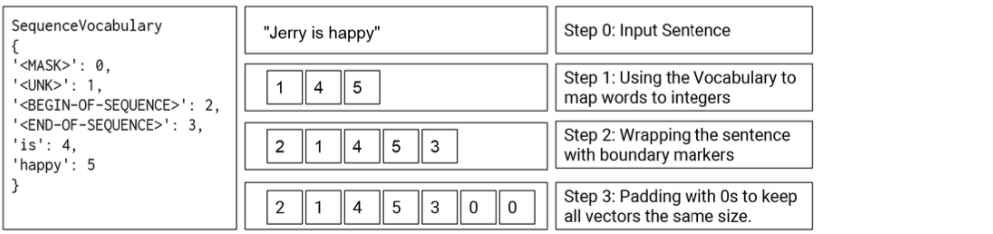
### - Expected behaviors:
#### (1) add_token(): to add new tokens to the Vocabulary
#### (2) lookup_token(): to retrieve the index for a token
#### (3) lookup_index(): to retrieve the token corresponding to a specific index.

In [6]:
class Vocabulary(object):

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """
        if token_to_idx is None:
            token_to_idx = {}
            
        self._token_to_idx = token_to_idx
        
        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            ### add a new element to _token_to_idx
            self._token_to_idx[token] = index
            ### add a new element to _idx_to_token
            self._idx_to_token[index] = token
        return index
   
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]
    
    def __len__(self):
        return len(self._token_to_idx)

In [7]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, 
                 token_to_idx    = None, 
                 unk_token       = "<UNK>",
                 mask_token      = "<MASK>", 
                 begin_seq_token = "<BEGIN>",
                 end_seq_token   = "<END>"):
        
        
        super().__init__(token_to_idx)
        """
        The follow attributes have been defined in the Vocabulary class:
            - ._token_to_idx
            - ._idx_to_token
        """

        self._mask_token      = mask_token      # default: "<MASK>"
        self._unk_token       = unk_token       # default: "<UNK>"
        self._begin_seq_token = begin_seq_token # default: "<BEGIN>"
        self._end_seq_token   = end_seq_token   # default: "<END>"

        self.mask_index       = self.add_token(self._mask_token)      # return 0
        self.unk_index        = self.add_token(self._unk_token)       # return 1
        self.begin_seq_index  = self.add_token(self._begin_seq_token) # return 2
        self.end_seq_index    = self.add_token(self._end_seq_token)   # return 3
        
    
    ### Overriding the self.lookup_token() method
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

## 1.3 - Vectorization
### [A walkthrough of codes](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Surname_Nationality/class_Vectorizer_tokenID_2.ipynb)
### - The class method **from_dataframe()** is used to instantiate a SurnameVectorizer object from a dataframe.
### - The SurnameVectorizer encapsulates the nationality vocabulary (nationality_vocab) and the surname vocabulary (surname_vocab).
### - The surname_vocab will be used as the reference for vector representation based on the Token IDs. Each unique token (character in this case) in the final vocabulary is assigned a unique numerical index or ID. In the vector, the i-th number represents the token ID for the i-th character.
### - The class method **vectorize()** is the core functionality of the Vectorizer. It takes as an argument a string representing a surname and returns a vector representation for the surname.

In [8]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, surname_vocab, nationality_vocab):
        """
        Args:
            surname_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.surname_vocab       = surname_vocab
        self.nationality_vocab   = nationality_vocab
         
    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab      = SequenceVocabulary()
        nationality_vocab  = Vocabulary()
        
        ########## Add tokens to surname_vocab and nationality_vocab
        for index, row in surname_df.iterrows():

            # Add tokens(characters) to surname_vocab
            for letter in row.surname:
                surname_vocab.add_token(letter)
            # Add tokens(words) to nationality_vocab
            nationality_vocab.add_token(row.nationality)

        return cls(surname_vocab, nationality_vocab)    
    
    def vectorize(self, surname, vector_length=-1):
        """
        Args:
            surname (str): the string of characters
            vector_length (int): an argument for forcing the length of index vector
        """
        ### set the first index to be begin_seq_index=2 (defined in SequenceVocabulary)
        indices = [self.surname_vocab.begin_seq_index]
        
        ### adding the indeces for the surname after the first index
        indices.extend(self.surname_vocab.lookup_token(token) 
                       for token in surname)
        
        ### set the last index to be end_seq_index=3 (defined in SequenceVocabulary)
        indices.append(self.surname_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices) - 1

        
        ### from_vector, will be used as SurnameDataset.x_data
        from_vector = np.empty(vector_length, dtype=np.int64)         
        from_indices = indices[:-1]
        from_vector[:len(from_indices)] = from_indices
        from_vector[len(from_indices):] = self.surname_vocab.mask_index
        
        ### to_vector, will be used as SurnameDataset.y_target
        to_vector = np.empty(vector_length, dtype=np.int64)
        to_indices = indices[1:]
        to_vector[:len(to_indices)] = to_indices
        to_vector[len(to_indices):] = self.surname_vocab.mask_index
        
        
        return from_vector, to_vector

## 1.4 - Batches
### [A walkthrough of codes](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Surname_Nationality/batch_generator.ipynb)

### - Group the vectorized data points into batches. 
### - The grouping is conducted throught the built in class **[DataLoader](https://pytorch.org/docs/stable/data.html)** in PyTorch. 
### - The class SurnameDataset inherits from the [**Dataset**](https://pytorch.org/vision/0.16/datasets.html) class. Instances of the derived class **SurnameDataset** can then be used with data loading tools like **DataLoader()** for efficient batch loading during model training.
### - The methods \_\_len\_\_(), and \_\_getitem\_\_() are defined in class **SurnameDataset** - these magic functions are expected by the **DataLoader()**. An object equipped with \_\_len\_\_() can be passed to the len() Python build-in function. For objects equipped with \_\_getitem\_\_() we can use the standard subscript for indexing tuples and lists to access individual items. 
### - The **DataLoader()** function utilizes the return results of the \_\_getitem\_\_() method in the dataset to construct batches of data. In each iteration, **DataLoader()** calls the \_\_getitem\_\_() method of the dataset to retrieve a sample, and then combines these samples into a batch. 
### - In **DataLoader()**, the \_\_getitem\_\_() method uses an index generated by the **Sampler** object. The **Sampler** is responsible for determining the indices of samples in each batch. This index may be generated sequentially or randomly, depending on the setting of the shuffle parameter.
### - Define a batch generator function that wraps the DataLoader and switch the data between the CPU and the GPU.

In [9]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        self.surname_df  = surname_df
        self._vectorizer = vectorizer
        
        ### SurnameVectorizer.vectorize() with be used with the parameter 
        ### vector_length = self._max_seq_length (the max length among all comments),
        ### so that the vectors for different rows will have the same length.
        ### +1 if only using begin_seq, +2 if using both begin and end seq tokens
        self._max_seq_length = max(map(len, self.surname_df.surname)) + 2
        
        self.train_df    = self.surname_df[self.surname_df.split=='train']
        self.train_size  = len(self.train_df)

        self.val_df      = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df     = self.surname_df[self.surname_df.split=='test']
        self.test_size   = len(self.test_df)
        
        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val'  : (self.val_df, self.validation_size),
                             'test' : (self.test_df, self.test_size)}
        self.set_split('train')
        
    @classmethod
    def load_csv_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        ### make vectorizer using training dataset
        train_surname_df = surname_df[surname_df.split=='train']
        new_vectorizer   = SurnameVectorizer.from_dataframe(train_surname_df)
        return cls(surname_df,new_vectorizer)
    
    @classmethod
    def load_df_and_make_vectorizer(cls,surname_df):
        """Load dataset and make a new vectorizer from scratch
        Args:
            surname_df: dataset
        Returns:
            an instance of SurnameDataset
        """
        ### make vectorizer using training dataset
        train_surname_df = surname_df[surname_df.split=='train']
        new_vectorizer   = SurnameVectorizer.from_dataframe(train_surname_df)
        return cls(surname_df,new_vectorizer)
    
    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        ### when split = 'train', _target_df means the training set
        self._target_df, self._target_size = self._lookup_dict[split]
        
    def __len__(self):
        ### _target_size is defined in set_split() 
        return self._target_size        
        
    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point: (x_data, y_target, class_index)
        """
        
        row = self._target_df.iloc[index]

        from_vector, to_vector = \
            self._vectorizer.vectorize(row.surname, self._max_seq_length)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_data'      : from_vector,
                'y_target'    : to_vector, 
                'class_index' : nationality_index}

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer
    
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  

### Generator Function

In [10]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device='cpu'):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset    = dataset, 
                            batch_size = batch_size,
                            shuffle    = shuffle, 
                            drop_last  = drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

### An example of one data batch

In [11]:
df_sample      = df_all.sample(100,random_state=101)
dataset_sample = SurnameDataset.load_df_and_make_vectorizer(df_sample)
batch_size     = 10
shuffle        = True
drop_last      = True
dataloader     = DataLoader(dataset    = dataset_sample, 
                            batch_size = batch_size,
                            shuffle    = shuffle, 
                            drop_last  = drop_last)

one_batch = next(iter(dataloader))
print('x_data in one batch')
print(one_batch['x_data'])
print('size of x_data:', one_batch['x_data'].shape)
print('-' * 60)
print('y_target in one batch')
print(one_batch['y_target'])
print('size of y_data:', one_batch['y_target'].shape)
print('-' * 60)
print('class_index')
print(one_batch['class_index'])

x_data in one batch
tensor([[ 2, 17, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2, 31, 12, 42, 12, 10,  5,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2,  4, 12, 20, 20, 18, 19,  6,  0,  0,  0,  0,  0,  0,  0],
        [ 2, 35, 26, 15,  6, 25,  9,  5,  9, 10,  0,  0,  0,  0,  0],
        [ 2, 34, 18, 14, 20,  5, 15,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2, 40,  8, 30, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2, 39,  8,  5,  9, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2, 21, 12, 15,  5,  6,  8,  9, 23,  6, 22, 26,  0,  0,  0],
        [ 2, 33, 25, 26,  6,  8,  9, 23,  0,  0,  0,  0,  0,  0,  0],
        [ 2, 32,  8, 12, 20,  8, 18, 14, 30,  0,  0,  0,  0,  0,  0]])
size of x_data: torch.Size([10, 15])
------------------------------------------------------------
y_target in one batch
tensor([[17, 18,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [31, 12, 42, 12, 10,  5,  3,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 4, 12, 20

### An example in one_batch

In [12]:
### from_vector, x_data
surname_index_from_vector = one_batch['x_data'][0]
print("from_vector:", surname_index_from_vector)
surname_text_from_vector  = "" 
for i in surname_index_from_vector.tolist():
    if i > 3:
        surname_text_from_vector+=dataset_sample._vectorizer.surname_vocab.lookup_index(i)
print("surname_text_from_vector:", surname_text_from_vector)

from_vector: tensor([ 2, 17, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
surname_text_from_vector: To


In [13]:
### to_vector, y_target
surname_index_to_vector = one_batch['y_target'][0]
print("to_vector:", surname_index_to_vector)
surname_text_to_vector  = "" 
for i in surname_index_to_vector.tolist():
    if i > 3:
        surname_text_to_vector+=dataset_sample._vectorizer.surname_vocab.lookup_index(i)
print("surname_text_to_vector:", surname_text_to_vector)

to_vector: tensor([17, 18,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
surname_text_to_vector: To


In [14]:
### nationality_index (class_index)
nationality_index = one_batch['class_index'][0]
print("nationality_index:", nationality_index)
nationality_text = dataset_sample._vectorizer.nationality_vocab.\
                   lookup_index(nationality_index.tolist())
print("nationality_text:", nationality_text)

nationality_index: tensor(2)
nationality_text: Russian


### The dimention of x_data is [batch_size, SurnameDataset._max_seq_length]

In [15]:
print("checking")
print(f"batch_size: {batch_size}")
print(f"SurnameDataset._max_seq_length: {dataset_sample._max_seq_length}")
print("-"*60)
df_temp = df_sample.copy()
df_temp['surname_len'] = df_temp.surname.apply(len)
print("Rows for the five longest suranmes")
longest = df_temp.sort_values(by='surname_len', ascending=False).reset_index().head(5)
print(longest)
print()
print(f"._max_seq_length is length of the longest surname in .surname_df +2")

checking
batch_size: 10
SurnameDataset._max_seq_length: 15
------------------------------------------------------------
Rows for the five longest suranmes
   index nationality  nationality_index  split        surname  surname_len
0   8254     Russian                 13  train  Davletkildeev           13
1   2400       Dutch                  2  train    Marqueringh           11
2   9210     Russian                 13  train    Janishevsky           11
3   1873       Czech                  5  train     Antonowitz           10
4   6027      German                  9  train     Schumacher           10

._max_seq_length is length of the longest surname in .surname_df +2


# @@@@@ 2. Model / Optimizer / Loss
## 2.1 - The model (RNN)

### - The **SurnameGenerationModel** inherits from PyTorch’s **Module**. The Surname Generation Model (SG_model) has three essential steps: nn.Embedding, a GRU RNN layer (using [nn.GRU](https://pytorch.org/docs/2.1/generated/torch.nn.GRU.html)) and a nn.Linear layer.  

### - Details about the GRU RNN layer is discussed [in this study](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Surname_Nationality/GRU_layer.ipynb).

### - Example of training word embeddings: [Learning the Continuous Bag of Words (CBOW) Embeddings](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Frankenstein/MAIN_frankenstein_Embedding.ipynb)

### - In PyTorch, the **nn.Module** class implements the **\_\_call\_\_** method, enabling model instances to be invoked like functions. Calling an instance from nn.Module with a set of arguments ends up calling a method named forward with the same argument. The forward function executes the forward computation, while **\_\_call\_\_** does other important chores before and after calling forward. In general, the correct way to call the module as a function is to use **SG_model(input)**, rather than **SG_model.forward(input)**, although they will produce the same outputs (silient errors, since there are steps not called properly if just using **forward(...)** directly).

### - Note that this conditioned model utilizes a specific nationality embedding as the initial hidden state (h_o in nn.GRU) of the RNN to allow the model to bias its predictions of sequences.
- Nationality embeddings are vectors representing the characteristics of a certain nationality. During training, these embedding vectors learn features related to each nationality. For example, for a particular nationality, the embedding vector may capture statistical patterns or specific characteristics of common surnames in that country.
- In sequence generation tasks, the initial hidden state (h_0) has a significant impact on the entire generated sequence. The GRU RNN model updates its hidden state at each time step. The initial hidden state provides the starting point for the generation process, influencing the output at each step and the computation of subsequent hidden states. This means that at each step of surname character generation, the hidden state and output of the GRU are influenced by the nationality embedding vector. Since the GRU's state updates are based on the previous hidden state and the current input character, the nationality information will gradually propagate and influence the entire generation process.
- Nationality embedding vectors are adjusted during training to best represent the characteristics of that nationality. When the model receives this initial embedding vector as h_0, it tends to generate surnames that bias to the characteristics of that nationality. For instance, if the initial hidden state is the embedding vector of a specific nationality, the model will be inclined to generate common surname patterns of that nationality, reflecting the statistical patterns and features carried by this embedding vector.


### - In contrast, in a unconditioned model ([see here](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Surname_Nationality/MAIN_unconditioned_surname_generation_GRU.ipynb)) is no speficif h_0 provided, it defaults to zeros. 

In [16]:
class SurnameGenerationModel(nn.Module):

    def __init__(self, 
                 embedding_dim, 
                 num_embeddings,
                 num_nationalities,
                 rnn_hidden_size, 
                 batch_first = True, 
                 padding_idx = 0,
                 dropout_p   = 0.5
                ):
        """
        Args:
            For embedding
            embedding_dim (int)    : The size of the character embeddings
            num_embeddings (int)   : The number of characters to embed
                                     len(surname_vocab)
            num_nationalities(int) : The size of the prediction vector 
            padding_idx (int)      : The index for the tensor padding
            
            For RNN
            rnn_hidden_size (int)  : The size of the RNN's hidden state
            batch_first (bool)     : Informs whether the input tensors will 
                                     have batch or the sequence on the 0th dimension
            For dropout
            dropout_p (float)      : The probability of zeroing activations using 
                                     the dropout method. Higher means more likely to zero.
            
        """
        super(SurnameGenerationModel, self).__init__()
        
        self.surname_emb = nn.Embedding(num_embeddings = num_embeddings,
                                        embedding_dim  = embedding_dim,
                                        padding_idx    = padding_idx)
        
        self.nationality_emb = nn.Embedding(num_embeddings = num_nationalities,
                                            embedding_dim  = rnn_hidden_size)
        
        self.rnn = nn.GRU(input_size   = embedding_dim,
                          hidden_size  = rnn_hidden_size,
                          batch_first  = batch_first)
        
        ### size of each output equals len(surname_vocab), 
        ### unlike the number of nationalities in the nationality prediction models.
        self.fc  = nn.Linear(in_features  = rnn_hidden_size,
                             out_features = num_embeddings)
        
        self._dropout_p = dropout_p
        
    def forward(self, x_in, nationality_index, apply_softmax=False):
        """The forward pass of the model
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            nationality_index (torch.Tensor): The index of the nationality for each data point
                Used to initialize the hidden state of the RNN
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_embeddings)
        """
        
        
        x_embedded = self.surname_emb(x_in)
        
        nationality_embedded = self.nationality_emb(nationality_index).unsqueeze(0)
        
        y_out,_    = self.rnn(x_embedded, nationality_embedded)

        batch_size, seq_size, feat_size = y_out.shape
        
        y_out = y_out.contiguous().view(batch_size * seq_size, feat_size)

        y_out = self.fc(F.dropout(y_out, p=self._dropout_p))
        
        
        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)
            
        new_feat_size = y_out.shape[-1]
        y_out = y_out.view(batch_size, seq_size, new_feat_size)
            
        return y_out

### Define the model 
### - Data: df_all
### - Training hyperparameters (batch_size, device): defined in args

In [17]:
dataset    = SurnameDataset.load_df_and_make_vectorizer(df_all)

vectorizer = dataset.get_vectorizer()

n_tokens_in_vocabulary = len(vectorizer.surname_vocab)
n_class                = len(vectorizer.nationality_vocab)
print(f"There are {n_tokens_in_vocabulary} tokens in the surname vocabulary.")
print(f"There are {n_class} classes in the nationality vocabulary.")

There are 80 tokens in the surname vocabulary.
There are 18 classes in the nationality vocabulary.


In [18]:
SG_model_temp = SurnameGenerationModel(embedding_dim   = 4,
                                       num_embeddings  = len(vectorizer.surname_vocab),
                                       num_nationalities=len(vectorizer.nationality_vocab),
                                       rnn_hidden_size = 3, 
                                       batch_first     = True, 
                                       padding_idx     = 0,
                                       dropout_p       = 0.5)

In [19]:
def print_parameters_model(model, print_shape=True, print_value=True):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Parameter name: {name}")
            if print_shape:
                print(f"Shape: {param.shape}")
                print("-"*100)
            if print_value:
                print(f"Weights: {param.data}")
                print("-"*100)

In [20]:
print_parameters_model(SG_model_temp,print_shape=True, print_value=False)

Parameter name: surname_emb.weight
Shape: torch.Size([80, 4])
----------------------------------------------------------------------------------------------------
Parameter name: nationality_emb.weight
Shape: torch.Size([18, 3])
----------------------------------------------------------------------------------------------------
Parameter name: rnn.weight_ih_l0
Shape: torch.Size([9, 4])
----------------------------------------------------------------------------------------------------
Parameter name: rnn.weight_hh_l0
Shape: torch.Size([9, 3])
----------------------------------------------------------------------------------------------------
Parameter name: rnn.bias_ih_l0
Shape: torch.Size([9])
----------------------------------------------------------------------------------------------------
Parameter name: rnn.bias_hh_l0
Shape: torch.Size([9])
----------------------------------------------------------------------------------------------------
Parameter name: fc.weight
Shape: torch.S

In [21]:
##### Outputs of SurnameGenerationModel
one_batch = next(iter(dataloader))
print("Shape of input:", one_batch['x_data'].shape)
print('-'*80)
print("Output (using initialized parameters, and specified h_0=one_batch['class_index'])")
pred = SG_model_temp(one_batch['x_data'],
                     nationality_index=one_batch['class_index'])
print("Shape:", pred.shape)
print('-'*80)
print("Applying softmax")
pred_softmax = SG_model_temp(one_batch['x_data'],
                             nationality_index=one_batch['class_index'],
                             apply_softmax=True)
print("Shape:", pred_softmax.shape)
print('-'*80)
print("Predicted category (index)")
pred_index = SG_model_temp(one_batch['x_data'],
                           nationality_index=one_batch['class_index'],
                           apply_softmax=True).max(dim=1)[1]
print(pred_index.shape)

Shape of input: torch.Size([10, 15])
--------------------------------------------------------------------------------
Output (using initialized parameters, and specified h_0=one_batch['class_index'])
Shape: torch.Size([10, 15, 80])
--------------------------------------------------------------------------------
Applying softmax
Shape: torch.Size([10, 15, 80])
--------------------------------------------------------------------------------
Predicted category (index)
torch.Size([10, 80])


In [22]:
##### Intermediate steps in SurnameGenerationModel
x_in                 = one_batch['x_data']
x_emb_in             = SG_model_temp.surname_emb(x_in)
nationality_embedded = SG_model_temp.nationality_emb(one_batch['class_index'])
h_0                  = nationality_embedded.unsqueeze(0)
output, h_n          = SG_model_temp.rnn(x_emb_in, h_0)

print("x_in, shape:", x_in.shape)
print("-"*80)
print("x_emb_in, shape:", x_emb_in.shape)
print("-"*80)
print("nationality_embedded, shape:", nationality_embedded.shape)
print(nationality_embedded)
print("-"*80)
print("nationality_embedded (unsqueezed), shape:", h_0.shape)
print(h_0)
print("-"*80)
print("output, shape:", output.shape)
print("-"*80)
print("h_n, shape:", h_n.shape)
print(h_n)

x_in, shape: torch.Size([10, 15])
--------------------------------------------------------------------------------
x_emb_in, shape: torch.Size([10, 15, 4])
--------------------------------------------------------------------------------
nationality_embedded, shape: torch.Size([10, 3])
tensor([[ 0.5580, -0.4048, -1.7990],
        [ 1.9964,  0.6977,  1.2950],
        [ 0.4551,  1.7414,  0.9142],
        [ 0.5580, -0.4048, -1.7990],
        [ 0.4551,  1.7414,  0.9142],
        [ 0.6474,  0.7338, -1.4027],
        [ 0.6474,  0.7338, -1.4027],
        [ 0.5580, -0.4048, -1.7990],
        [ 0.5580, -0.4048, -1.7990],
        [ 0.5580, -0.4048, -1.7990]], grad_fn=<EmbeddingBackward0>)
--------------------------------------------------------------------------------
nationality_embedded (unsqueezed), shape: torch.Size([1, 10, 3])
tensor([[[ 0.5580, -0.4048, -1.7990],
         [ 1.9964,  0.6977,  1.2950],
         [ 0.4551,  1.7414,  0.9142],
         [ 0.5580, -0.4048, -1.7990],
         [ 0.45

### Define the formal SG_model

In [23]:
dataset    = SurnameDataset.load_df_and_make_vectorizer(df_all)

vectorizer = dataset.get_vectorizer()

SG_model   = SurnameGenerationModel(embedding_dim     = args.embedding_dim,
                                    num_embeddings    = len(vectorizer.surname_vocab),
                                    num_nationalities = len(vectorizer.nationality_vocab),
                                    rnn_hidden_size   = args.rnn_hidden_size, 
                                    batch_first       = True, 
                                    padding_idx       = 0,  
                                    ### or padding_idx = vectorizer.surname_vocab.mask_index
                                    dropout_p         = 0.5)

## 2.2 - The loss function (Binary Cross-Entropy)
### - The loss - "how far off" the model predictions are from the target.
### - The gradient of the loss function - a signal for “how much” the parameters should change (according to "how much" each parameter contributed to the loss function).
### - As mentioned, the loss function should be appropriate for the activation function.

In [24]:
def normalize_sizes(y_pred, y_true):
    """Normalize tensor sizes
    
    Args:
        y_pred (torch.Tensor): the output of the model
            If a 3-dimensional tensor, reshapes to a matrix
        y_true (torch.Tensor): the target predictions
            If a matrix, reshapes to be a vector
    """

    if len(y_pred.size()) == 3:
        y_pred = y_pred.contiguous().view(-1, y_pred.size(2))
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)

    return y_pred, y_true

def sequence_loss(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    return F.cross_entropy(y_pred, y_true, ignore_index=mask_index)

In [25]:
torch.manual_seed(42)
y_pred = torch.rand(5, 2, 20)
y_true = torch.randint(0, 20, (5, 2))

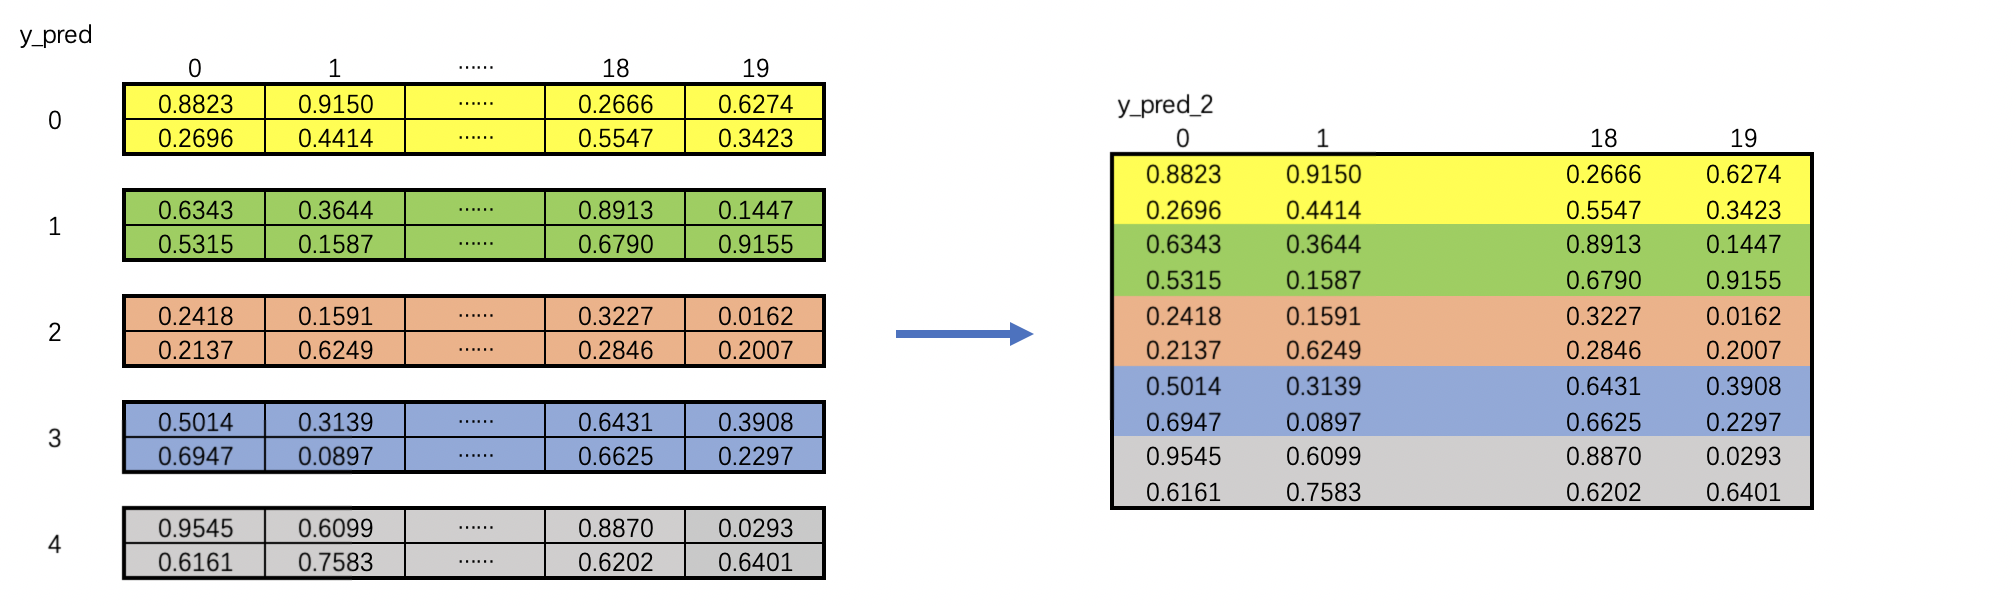

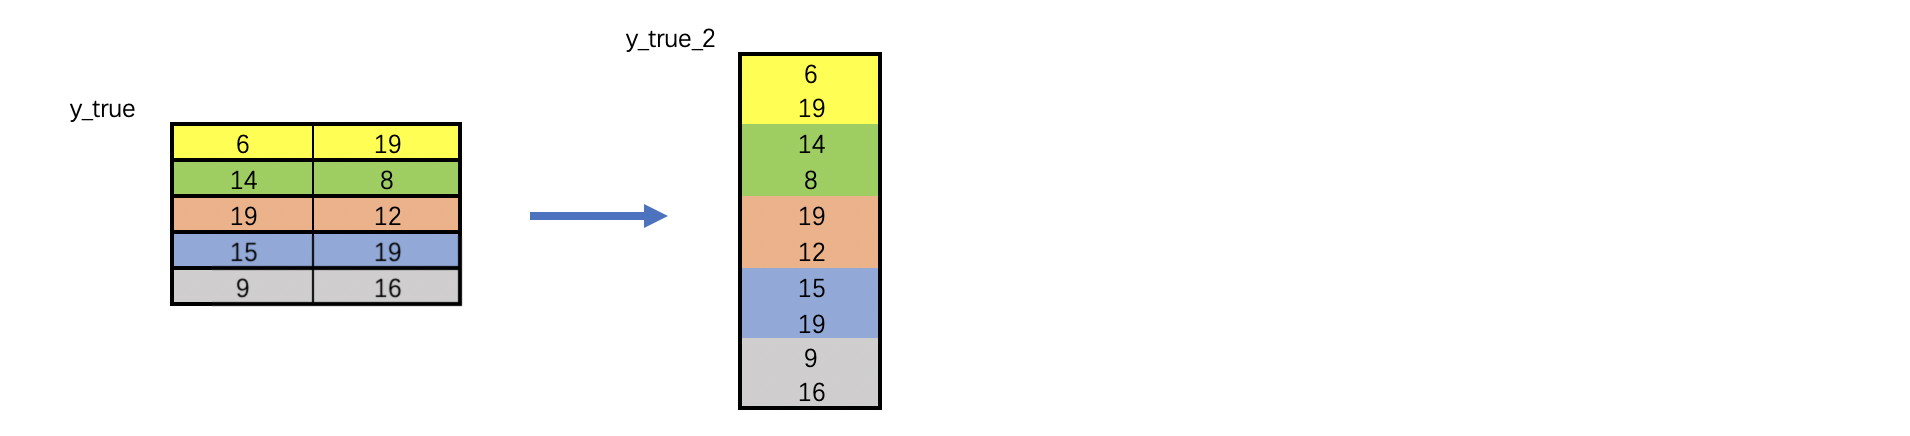

In [26]:
print("Before running normalize_sizes()")
print("y_pred, shape:", y_pred.shape)
print("y_true, shape:", y_true.shape)
print("-"*60)
print("After running normalize_sizes()")
y_pred_2, y_true_2 = normalize_sizes(y_pred, y_true)
print("y_pred_2, shape:", y_pred_2.shape)
print("y_true_2, shape:", y_true_2.shape)

Before running normalize_sizes()
y_pred, shape: torch.Size([5, 2, 20])
y_true, shape: torch.Size([5, 2])
------------------------------------------------------------
After running normalize_sizes()
y_pred_2, shape: torch.Size([10, 20])
y_true_2, shape: torch.Size([10])


In [27]:
##### An example
one_batch = next(iter(dataloader))

y_pred    = SG_model(x_in = one_batch['x_data'], 
                     nationality_index = one_batch['class_index'])
y_true    = one_batch['y_target']

sequence_loss(y_pred, y_true, vectorizer.surname_vocab.mask_index)

tensor(4.3729, grad_fn=<NllLossBackward0>)

## 2.3 - The optimizer and scheduler
### The initialized state of the SG_model
### Using [torch.nn.Module.parameters](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters)
#### These are the tensors that the optimizer will get. After calling **model.backward()** the parameters are populated with their grad, and the optimizer then updates their values accordingly during the **optimizer.step()** call.
#### The requires_grad = True argument is telling PyTorch to track the entire family tree of tensors resulting from operations on *parameters*.

In [28]:
SG_model

SurnameGenerationModel(
  (surname_emb): Embedding(80, 32, padding_idx=0)
  (nationality_emb): Embedding(18, 32)
  (rnn): GRU(32, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=80, bias=True)
)

### Define the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer 
#### - the learning rate is set adaptively
#### - it is not sensitive to the scaling of the parameters

In [29]:
optimizer = optim.Adam(SG_model.parameters(), lr=args.learning_rate)

### Apply a scheduler for adjusting learning rate
### - [torch.optim.lr_scheduler](https://pytorch.org/docs/stable/optim.html) provides several methods to adjust the learning rate based on the number of epochs.
### - [torch.optim.lr_scheduler.ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau) allows dynamic learning rate reducing based on some validation measurements.
### - This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced.
### - Parameters:
1. **mode(str)**: In "min" mode, lr will be reduced when the quantity monitored has stopped decreasing; in "max" mode it will be reduced when the quantity monitored has stopped increasing. Default: 0.1.
2. **factor(float)**: Factor by which the learning rate will be reduced. new_lr = lr * factor. Default: 0.1.
3. **patience (int)**: Number of epochs with no improvement after which learning rate will be reduced. For example, if patience = 2, then we will ignore the first 2 epochs with no improvement, and will only decrease the LR after the 3rd epoch if the loss still hasn’t improved then. Default: 10.
4. **threshold (float)** – Threshold for measuring the new optimum, to only focus on significant changes. Default: 1e-4.

### - A **scheduler.step(val_loss)** method is called at the end of each epoch to execute the update of the learning rate. The parameters “val_loss” represents the loss (or other monitoring metric) computed for the model on the validation set. This loss value is typically used by the scheduler to assess the model's performance on the validation set and update the learning rate accordingly.
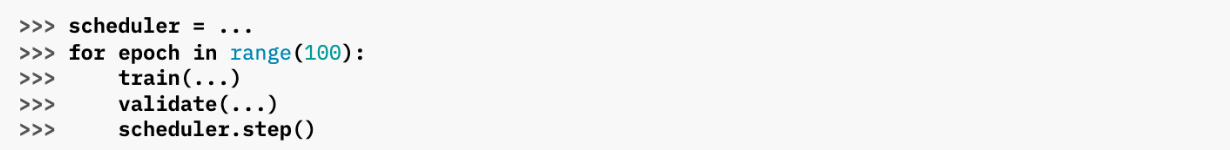

In [30]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer,
                                                 mode      = 'min', 
                                                 factor    = 0.5,
                                                 patience  = 1)

# @@@@@ 3. Training Routine
## 3.1 - Helper function: tracking the training state

In [31]:
def init_train_state(args):
    train_state_dict = {'stop_early'    : False,
                        'early_stopping_step'     : 0,
                        'early_stopping_best_val' : 1e8,
                        'learning_rate' : args.learning_rate,
                        'epoch_index'   : 0,
                        'train_loss'    : [],
                        'train_acc'     : [],
                        'val_loss'      : [],
                        'val_acc'       : [],
                        'test_loss'     : -1,
                        'test_acc'      : -1,
                        'model_filename': args.save_model_name
                       }
    return train_state_dict

def update_train_state(args, model, train_state):
    """
    Handle the training state updates.
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    Args:
        args:  arguments
        model: model to train
        train_state: a dictionary representing the training state values
    
    Returns:
        a new train_state
    """

    # Save the first model
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss increased (not a better model)
        if loss_t >= train_state['early_stopping_best_val']:
            # Update early_stopping_step
            train_state['early_stopping_step'] += 1
        # If loss decreased
        else:
            # Save the best model and update the early_stopping_best_val
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        # In the main training loop, if train_state['stop_early']: break
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

## 3.2 - Helper function: compute accurary rate

In [32]:
def compute_accuracy(y_pred, y_true, mask_index, device):
    y_pred, y_true = normalize_sizes(y_pred, y_true)

    _, y_pred_indices = y_pred.max(dim=1)
    
    correct_indices = torch.eq(y_pred_indices, y_true).float()
    valid_indices = torch.ne(y_true, mask_index).float()
    
    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = valid_indices.sum().item()

    return n_correct / n_valid * 100

In [33]:
##### An example
one_batch = next(iter(dataloader))
y_pred    = SG_model(x_in = one_batch['x_data'],
                     nationality_index = one_batch['class_index'])
targets   = one_batch['y_target']

In [34]:
compute_accuracy(y_pred,
                 targets,
                 vectorizer.surname_vocab.mask_index,
                 device='cpu')

2.631578947368421

In [35]:
### Same function as compute_accuracy(), but prints some steps
def compute_accuracy_verbose(y_pred, y_true, mask_index, device):
    print("Before running normalize_sizes()")
    print("y_pred,", y_pred.shape)
    print("y_true,", y_true.shape)
    print("-"*60)
    
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    print("After running normalize_sizes()")
    print("y_pred,", y_pred.shape)
    print("y_true,", y_true.shape)
    print("-"*60)
    
    _, y_pred_indices = y_pred.max(dim=1)
    print("y_pred_indices:", y_pred_indices)
    print("y_true:", y_true)
    
    correct_indices = torch.eq(y_pred_indices, y_true).float()
    valid_indices   = torch.ne(y_true, mask_index).float()
    
    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid   = valid_indices.sum().item()
    print("n_correct:", n_correct)
    print("n_valid:", n_valid)
    return n_correct / n_valid * 100

In [36]:
compute_accuracy_verbose(y_pred,
                         targets,
                         vectorizer.surname_vocab.mask_index,
                         device='cpu')

Before running normalize_sizes()
y_pred, torch.Size([10, 15, 80])
y_true, torch.Size([10, 15])
------------------------------------------------------------
After running normalize_sizes()
y_pred, torch.Size([150, 80])
y_true, torch.Size([150])
------------------------------------------------------------
y_pred_indices: tensor([ 2, 59,  6, 51, 45, 13, 41, 36,  3,  0,  3, 56,  2, 51,  1, 38,  2, 37,
        37,  8, 45, 51, 51,  1,  1, 37,  2,  1,  2,  2, 51, 41, 21, 76, 51, 51,
        51, 13,  2, 56, 21,  1,  1,  1,  2,  0, 51, 31,  6, 36, 13,  1, 37,  2,
         2, 56, 56,  3, 51,  1, 75, 40, 46, 14, 31, 22, 51, 71, 71, 13,  3,  1,
         1,  2, 21, 61, 13, 16, 56, 46,  2, 40, 51, 33,  2,  2,  1,  2,  2,  1,
        21, 66, 21, 10,  7,  7, 51,  7, 13,  1,  2,  1,  2,  2,  2,  7, 51, 62,
        62,  8, 59, 13, 21, 13,  2, 59,  1,  2,  1, 21, 13, 31,  7, 64, 21, 64,
        51,  1,  2, 37,  1,  1,  1, 21,  2, 16, 55, 59, 64, 59, 33, 58, 41, 51,
        46, 21, 51, 45,  2,  3])
y_true

2.631578947368421

## 3.3 - Training loop
### - The training loop updates the model parameters so that it improves over time.
### - The training loop is composed of two loops: an inner loop over batches in the dataset, and an outer loop, which repeats the inner loop a number of times.
### - The inner loop (batch), losses are computed for each batch, and the optimizer is used to update the model parameters.

In [37]:
def print_train_state(train_state):
    print('Train Loss:',round(train_state['train_loss'][-1],5))
    print('Train Accuracy:',round(train_state['train_acc'][-1],5))
    print('Valid Loss:',round(train_state['val_loss'][-1],5))
    print('Valid Accuracy:',round(train_state['val_acc'][-1],5))
    print('early_stopping_best_val:',round(train_state['early_stopping_best_val'],5))
    print('early_stopping_step:',train_state['early_stopping_step'])
    print('stop_early:',train_state['stop_early'])

In [38]:
mask_index = vectorizer.surname_vocab.mask_index
mask_index

0

In [39]:
if args.get_model == 'TRAIN':
    ##### Get an initialized train_state
    train_state = init_train_state(args)
    
    for epoch_index in range(args.num_epochs):
        print('-'*60)
        print(f'Epoch {epoch_index}...')
        train_state['epoch_index'] = epoch_index

        ##################################################
        #####     Iterate over training dataset      #####
        ##################################################
        print('Training Iteration...')

        ##### Create a batch_generator using training data
        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                           batch_size = args.batch_size,
                                           device     = args.device)

        ##### running_loss and running_acc are equivalent to the moving averages of loss and accuracy.
        ##### when the loop ends, a moving average is just an average. 
        ##### In each epoch loop, they are reset to zero before the batch loop.
        running_loss = 0.0
        running_acc  = 0.0

        ##### Indicate that the model is in “training mode” 
        # makes the model parameters mutable 
        # and enables regularization mechanisms like dropout
        SG_model.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:
            # --------------------------------------
            ##### STEP 1. zero the gradients
            # Inside each batch iteration, the optimizer’s gradients are first reset
            # Calling backward (step 4 below) will ACCUMULATE gradients, so if the backward()
            # is called earlier, the new gradient is accumulated on top of the one computed 
            # in previous iterations, which leads to an incorrect value for the gradient.
            # Therefore, use this zero_ method to reset the gradients.
            optimizer.zero_grad()

            ##### STEP 2. compute the output
            y_pred = SG_model(x_in = batch_dict['x_data'],
                              nationality_index=batch_dict['class_index'])
            
            ##### STEP 3. compute the loss
            loss   = sequence_loss(y_pred, batch_dict['y_target'], mask_index)
            loss_t = loss.item()
            # update the moving average of loss, batch by batch
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            ##### STEP 4. use loss to produce gradients (gradients are propagated to each parameter)
            # Calling backward() and the gradients at each leaf is ACCUMULATED, not stored.
            # Note that the loss is the loss in train split. There is no valid_loss.backward()
            # because we don't want to train the model on the validation data. 
            loss.backward()

            ##### STEP 5. use optimizer to update parameters
            # the optimizer uses the propagated gradients to perform parameter updates
            # The value of SG_model.parameters(), i.e., params is automatically updated in this step. 
            # In specific, the optimizer looks into params.grad and updates params, by substracting 
            # learning_rate * grad from it. 
            optimizer.step()

            ##### Tracking the accuracy
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, 
                                     batch_dict['y_target'],
                                     mask_index,
                                     args.device)
            # update the moving average of acc, batch by batch
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        ##### After this inner loop (training) ends
        # Append the running_loss and running_acc to train_state
        # (the average of loss and acc in all the batches in the current epoch)
        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        ##################################################
        #####     Iterate over validation dataset    #####
        ##################################################
        print('Validation Iteration...')

        ##### Create a batch_generator using validation data
        dataset.set_split('val')    
        batch_generator = generate_batches(dataset, 
                                           batch_size = args.batch_size, 
                                           device     = args.device)
        ##### Create new running loss, and running accuracy
        running_loss = 0.0
        running_acc  = 0.0

        ##### Indicate that the model is in “evaluation mode”
        # makes the model parameters immutable 
        # disables dropout
        # disables computation of the loss and propagation of gradients back to the parameters
        SG_model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            ##### compute the output
            y_pred = SG_model(x_in = batch_dict['x_data'],
                              nationality_index=batch_dict['class_index'])

            ##### STEP 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            ##### compute the accuracy
            acc_t = compute_accuracy(y_pred, 
                                     batch_dict['y_target'],
                                     mask_index,
                                     args.device)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        ##### After this inner loop (validation) ends
        # Append the running_loss and running_acc to train_state
        # (the average of loss and acc in all the batches in the current epoch)
        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        ##### Update the status of Early Stopping and Model Checkpoint
        # Input: the current SG_model and current train_state (end of the current epoch loop)
        # Update three items in train_state
        # 1."early_stopping_step" +=1 or reset to 0 (comparing val_loss and early_stopping_best_val)
        # 2."early_stopping_best_val" update to the current val_loss if it is the best model
        # 3."stop_early" if early_stopping_step reaches early_stopping_criteria. If True, break all loops below. 
        # Save a new model if the current model has early_stopping_best_val
        train_state = update_train_state(args        = args, 
                                         model       = SG_model,
                                         train_state = train_state)
        
        scheduler.step(train_state['val_loss'][-1])
        print('Current lr:', optimizer.param_groups[0]['lr'])

        print_train_state(train_state)

        if train_state['stop_early']:
            break

elif args.get_model == 'LOAD':
    SG_model.load_state_dict(torch.load(train_state['model_filename']))
    SG_model = SG_model.to(args.device)

------------------------------------------------------------
Epoch 0...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 3.94089
Train Accuracy: 11.73977
Valid Loss: 3.35108
Valid Accuracy: 15.37139
early_stopping_best_val: 100000000.0
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 1...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 3.15326
Train Accuracy: 17.25967
Valid Loss: 3.00194
Valid Accuracy: 19.05914
early_stopping_best_val: 3.00194
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 2...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 2.91242
Train Accuracy: 20.23533
Valid Loss: 2.84053
Valid Accuracy: 20.86912
early_stopping_best_val: 2.84053
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 3...
Training Iteration...
Va

Validation Iteration...
Current lr: 0.001
Train Loss: 2.44565
Train Accuracy: 28.1829
Valid Loss: 2.45959
Valid Accuracy: 27.92122
early_stopping_best_val: 2.45959
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 28...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 2.44288
Train Accuracy: 28.31547
Valid Loss: 2.45669
Valid Accuracy: 27.7695
early_stopping_best_val: 2.45669
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 29...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 2.4369
Train Accuracy: 28.496
Valid Loss: 2.44229
Valid Accuracy: 27.64341
early_stopping_best_val: 2.44229
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 30...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 2.43196
Train Accuracy: 28.56868
Valid Loss: 2.4

# @@@@@ 4. Evaluation
## 4.1 - Evaluation on Test Data

In [40]:
SG_model = SurnameGenerationModel(embedding_dim     = args.embedding_dim,
                                  num_embeddings    = len(vectorizer.surname_vocab),
                                  num_nationalities = len(vectorizer.nationality_vocab),
                                  rnn_hidden_size   = args.rnn_hidden_size,
                                  batch_first       = True,
                                  padding_idx       = 0,
                                  ### or padding_idx = mask_index
                                  dropout_p         = 0.5)
filename   = args.output_path + args.save_model_name
SG_model.load_state_dict(torch.load(filename))
SG_model = SG_model.to(args.device)

##### Create a batch_generator using test data
# The test set should be run as little as possible
# Avoid make a new model decision based on the evaluation on test data
# Otherwise the model might be biased toward the test data, and the test data will 
# become meaningless as an measure of truly held-out data.
dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)

##### Create new running loss, and running accuracy
running_loss = 0.0
running_acc  = 0.0

##### Indicate that the model is in “evaluation mode”
SG_model.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = SG_model(x_in=batch_dict['x_data'], 
                      nationality_index=batch_dict['class_index'])

 # compute the loss
    loss   = sequence_loss(y_pred, batch_dict['y_target'], mask_index)
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, 
                             batch_dict['y_target'],
                             mask_index,
                             args.device)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

print("Test loss: {:.5f}".format(running_loss))
print("Test Accuracy: {:.5f}".format(running_acc))   

Test loss: 2.46600
Test Accuracy: 28.01314


### 4.2 Generation a surname with given max length
### Even though the per-character accuracy of the predictions is a measure of model performance, it is better in this example to do qualitative evaluation by inspecting what kinds of surnames the model will generate.

### Function sample_from_model(): 
- A loop over a modified version of the steps in the forward() method to compute predictions at each time step and use those predictions as the input to the following time step. 
- The output of the model (SG_model) at each time step is a prediction vector which is turned into a probability distribution using the softmax function. 
- Using the probability distribution, the torch.multinomial() sampling function selects an index at a rate proportional to the probability of the index.

### Function decode_samples():
- Transform the sampled indices from the sample_from_model() function into a string output. 
- In creating the string, we use only the indices up to the END-OF-SEQUENCE index. This assumes that the model learns some sense of when surnames should end. (If the END-OF-SEQUENCE index does not appear, the entire sample index will be transformed to a string.) 

In [41]:
def sample_from_model(model, vectorizer, nationalities, sample_size=20, 
                      temperature=1.0):
    """Sample a sequence of indices from the model
    
    Args:
        model (SurnameGenerationModel): the trained model
        vectorizer (SurnameVectorizer): the corresponding vectorizer
        nationalities (list): a list of integers representing nationalities
        sample_size (int): the max length of the samples
        temperature (float): accentuates or flattens 
            the distribution. 
            0.0 < temperature < 1.0 will make it peakier. 
            temperature > 1.0 will make it more uniform
    Returns:
        indices (torch.Tensor): the matrix of indices; 
        shape = (num_samples, sample_size)
    """
    num_samples = len(nationalities)
    
    begin_seq_index = [vectorizer.surname_vocab.begin_seq_index 
                       for _ in range(num_samples)]
    begin_seq_index = torch.tensor(begin_seq_index, 
                                   dtype=torch.int64).unsqueeze(dim=1)
    indices = [begin_seq_index]
    
    nationality_indices = torch.tensor(nationalities, dtype=torch.int64).unsqueeze(dim=0)
    h_t     = model.nationality_emb(nationality_indices)
    
    for time_step in range(sample_size):
        x_t                = indices[time_step]
        x_emb_t            = model.surname_emb(x_t)
        rnn_out_t, h_t     = model.rnn(x_emb_t, h_t)
        prediction_vector  = model.fc(rnn_out_t.squeeze(dim=1))
        probability_vector = F.softmax(prediction_vector / temperature, dim=1)
        indices.append(torch.multinomial(probability_vector, num_samples=1))
    indices = torch.stack(indices).squeeze().permute(1, 0)
    return indices

def decode_samples(sampled_indices, vectorizer):
    """Transform indices into the string form of a surname
    
    Args:
        sampled_indices (torch.Tensor): the inidces from `sample_from_model`
        vectorizer (SurnameVectorizer): the corresponding vectorizer
    """
    decoded_surnames = []
    vocab = vectorizer.surname_vocab
    
    for sample_index in range(sampled_indices.shape[0]):
        surname = ""
        for time_step in range(sampled_indices.shape[1]):
            sample_item = sampled_indices[sample_index, time_step].item()
            if sample_item == vocab.begin_seq_index:
                continue
            elif sample_item == vocab.end_seq_index:
                break
            else:
                surname += vocab.lookup_index(sample_item)
        decoded_surnames.append(surname)
    return decoded_surnames

In [42]:
### Same function as sample_from_model(), but prints some steps
def sample_from_model_verbose(model,
                              vectorizer,
                              nationalities,
                              sample_size=20,
                              temperature=1.0):
    """Sample a sequence of indices from the model
    
    Args:
        model (SurnameGenerationModel): the trained model
        vectorizer (SurnameVectorizer): the corresponding vectorizer
        nationalities (list): a list of integers representing nationalities
        sample_size (int): the max length of the samples
        temperature (float): accentuates or flattens 
            the distribution. 
            0.0 < temperature < 1.0 will make it peakier. 
            temperature > 1.0 will make it more uniform
    Returns:
        indices (torch.Tensor): the matrix of indices; 
        shape = (num_samples, sample_size)
    """
    num_samples = len(nationalities)
    
    begin_seq_index = [vectorizer.surname_vocab.begin_seq_index 
                       for _ in range(num_samples)]
    print("begin_seq_index:", begin_seq_index)
    print("-"*80)
    begin_seq_index = torch.tensor(begin_seq_index, 
                                   dtype=torch.int64).unsqueeze(dim=1)
    print("begin_seq_index(unsqueezed):")
    print(begin_seq_index)
    print("-"*80)
    
    indices = [begin_seq_index]
    print("indices:", indices)
    print("-"*80)
    
    nationality_indices = torch.tensor(nationalities, dtype=torch.int64).unsqueeze(dim=0)
    print("nationalities:", nationalities)
    print("nationality_indices:", nationality_indices)
    print("-"*80)
    h_t     = model.nationality_emb(nationality_indices)
    print("h_t, shape:", h_t.shape)
    print(h_t)
    print("-"*80)
    
    for time_step in range(sample_size):
        
        x_t = indices[time_step]
        if time_step==0:
            print("For time_step = 0")
            print("-"*80)
            print("x_t:", x_t)
            print("shape:", x_t.shape)
            print("-"*80)
        x_emb_t = model.surname_emb(x_t)
        if time_step==0:
            print("x_emb_t:", x_emb_t)
            print("shape:", x_emb_t.shape)
            print("-"*80)
        rnn_out_t, h_t = model.rnn(x_emb_t, h_t)
        prediction_vector  = model.fc(rnn_out_t.squeeze(dim=1))
        if time_step==0:
            print("prediction_vector:", prediction_vector)
            print("shape:", prediction_vector.shape)
            print("-"*80)
        probability_vector = F.softmax(prediction_vector / temperature, dim=1)
        if time_step==0:
            print("probability_vector:", probability_vector)
            print("shape:", probability_vector.shape)
            print("-"*80)
        
        index_now = torch.multinomial(probability_vector, num_samples=1)
        print(f"Sample at time_step {time_step}:", index_now)
        indices.append(index_now)
    print("-"*80)
    print("indices:")
    print(indices)
    print("-"*80)
    indices = torch.stack(indices).squeeze().permute(1, 0)
    print("-"*80)
    print("indices (after squeeze/permute):")
    print(indices)
    print("-"*80)
    return indices


In [43]:
nationalities = np.random.choice(np.arange(len(vectorizer.nationality_vocab)), replace=True, size=2)
index_sample = sample_from_model_verbose(model = SG_model,
                                         vectorizer = vectorizer,
                                         nationalities = nationalities,
                                         sample_size = 5, 
                                         temperature = 1.0
                                        )

begin_seq_index: [2, 2]
--------------------------------------------------------------------------------
begin_seq_index(unsqueezed):
tensor([[2],
        [2]])
--------------------------------------------------------------------------------
indices: [tensor([[2],
        [2]])]
--------------------------------------------------------------------------------
nationalities: [11 16]
nationality_indices: tensor([[11, 16]])
--------------------------------------------------------------------------------
h_t, shape: torch.Size([1, 2, 32])
tensor([[[-0.6741, -0.6329,  0.7349,  0.8786,  1.5295,  0.3341,  0.3295,
          -1.3951,  0.8325, -2.6311, -1.3975,  0.0074,  1.6838,  0.4002,
          -0.4944, -0.2933, -0.1013, -0.5524, -1.2609,  0.0178,  0.3174,
           0.9782,  1.7496,  0.4213, -0.8023,  0.1426,  0.9056,  3.5505,
           1.0265, -0.4834,  1.1363,  0.4364],
         [ 1.0454,  0.1140, -0.5959,  0.2183,  0.0823, -0.9751, -0.8107,
          -0.9413,  0.6904, -0.4262,  0.9399, -0

In [44]:
### Same function as decode_samples(), but prints some steps
def decode_samples_verbose(sampled_indices, vectorizer):
    """Transform indices into the string form of a surname
    
    Args:
        sampled_indices (torch.Tensor): the inidces from `sample_from_model`
        vectorizer (SurnameVectorizer): the corresponding vectorizer
    """
    decoded_surnames = []
    vocab = vectorizer.surname_vocab
    print(f"Length of surname_vocab: {len(vocab)}")
    print("-"*80)
    print("sampled_indices, shape:", sampled_indices.shape)
    for sample_index in range(sampled_indices.shape[0]):
        print(f"Sample {sample_index}:")
        surname = ""
        for time_step in range(sampled_indices.shape[1]):
            sample_item = sampled_indices[sample_index, time_step].item()
            print("sample_item:", sample_item)
            if sample_item == vocab.begin_seq_index:
                continue
            elif sample_item == vocab.end_seq_index:
                break
            else:
                surname += vocab.lookup_index(sample_item)
                print("updated surname:", surname)
        decoded_surnames.append(surname)
        print("-"*80)
    return decoded_surnames

In [45]:
sampled_surnames = decode_samples_verbose(index_sample, vectorizer)
sampled_surnames

Length of surname_vocab: 80
--------------------------------------------------------------------------------
sampled_indices, shape: torch.Size([2, 6])
Sample 0:
sample_item: 2
sample_item: 54
updated surname: U
sample_item: 8
updated surname: Uh
sample_item: 7
updated surname: Uha
sample_item: 18
updated surname: Uhae
sample_item: 15
updated surname: Uhaer
--------------------------------------------------------------------------------
Sample 1:
sample_item: 2
sample_item: 29
updated surname: G
sample_item: 23
updated surname: Gi
sample_item: 31
updated surname: Gil
sample_item: 16
updated surname: Gily
sample_item: 27
updated surname: Gilys
--------------------------------------------------------------------------------


['Uhaer', 'Gilys']

In [46]:
### Generate 3 surnames for each nationality
for index in range(len(vectorizer.nationality_vocab)):
    nationality = vectorizer.nationality_vocab.lookup_index(index)
    print("Sampled for {}: ".format(nationality))
    sampled_indices = sample_from_model(SG_model, vectorizer,  
                                        nationalities=[index] * 3, 
                                        ### Generate 3 surnames for each nationality
                                        temperature=0.7)
    for sampled_surname in decode_samples(sampled_indices, vectorizer):
        print("-  " + sampled_surname)

Sampled for Arabic: 
-  Sarase
-  Hadsi
-  Sura
Sampled for Chinese: 
-  Fon
-  Hor
-  Los
Sampled for Czech: 
-  Farra
-  Batim
-  Fansin
Sampled for Dutch: 
-  Loesse
-  Molal
-  Letwas
Sampled for English: 
-  Mamdan
-  Ellkal
-  Slinga
Sampled for French: 
-  Aherien
-  Satton
-  Engiew
Sampled for German: 
-  Solkascon
-  Sardan
-  Fouellan
Sampled for Greek: 
-  Adabri
-  Hachonhi
-  Aber
Sampled for Irish: 
-  Alnan
-  Supsida
-  Salnamere
Sampled for Italian: 
-  Perla
-  Amaba
-  Moiav
Sampled for Japanese: 
-  Hamasomibe
-  Sahatees
-  Tanach
Sampled for Korean: 
-  Asttti
-  Ra
-  Sh
Sampled for Polish: 
-  Harmad
-  Biward
-  Uchlov
Sampled for Portuguese: 
-  Echer
-  Jikan
-  Ssae
Sampled for Russian: 
-  Foniv
-  Lennan
-  Jihin
Sampled for Scottish: 
-  Worhe
-  Alsteln
-  Orolin
Sampled for Spanish: 
-  Baber
-  Tarman
-  Allibapy
Sampled for Vietnamese: 
-  Bo
-  Mutda
-  Dari
